# Technical Write-Up
## Predicting Flight Delays for US Domestic Flights 
### Hal Wright -  June 2016

### Dataset and Project Goals

Organizing commercial air travel is a logistical issue that impacts a large number of citizens in the US
on a daily basis. Every year there are millions of domestic flights in the US and, in 2015, about 38%
percent of all domestic flights were delayed. As a Bay Area resident, I wanted to build a feature that
would help consumers in the Bay Area avoid delays. My goal in this project was to build a model
that could predict the chance of delay for the same flight at each of the three Bay Area airports (San
Jose, San Francisco, and Oakland). The Research and Innovative Technology Administration (RITA)
has published on time performance data for all US domestic flights from January 1987 to January 2016.
I used this data, machine learning techniques, and user input modules to create my model.

### Importing and Cleaning the Data

When looking to find a data sets to help build my model and user input feature. RITA's dataset was the best choice because it was so expanseive the whole dataset totals over 165 million domestic flights spanning back to 1987. The data is broken up into .csv files for every month in that span. A total of 349 file (data is through January 2016) and over 165 million flights (rows). As I was only concerned with the Bay Area Airports I neeed to segment my data down to flights originating in the Bay Area. I also needed to only include flight that land at one of the 21 shared destinations of the Bay Area airports so that I could create valid comparisons between flying out of the three different airports. I also decided to only use data from the most recent full year of data (2015), this gave me the most recent and comparable data while also pairing down my data to a reasonable size that I could work with in the scope of this project.

To do this I created lists the unique destinations for each airport, then I created a final list that only had the
airports that were in all three of the unique destinations lists. After creating the final list I used the common destinations list to create a new binary field in the data set that would denote if the destination of any given flight was a part of the common destinations field. I created a similar binary field for if flights originated in
the bay area. After creating those two fields I used a mask to keep only the flights were both of those field were
populated with a 1. I also used a mask to remove all of the cancelled flights because my target was delayed flights and cancelled flights were odd outliers that shouldn't be included in the data.

In [2]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV, LinearRegression
from sklearn.cross_validation import train_test_split, cross_val_score
import patsy
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix


from ipywidgets import *
from IPython.display import display
from ipywidgets import Dropdown
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

from PIL import Image
from gcmap import GCMapper
import random


plt.style.use('seaborn-white')

%matplotlib inline

In [2]:
#Importing RITA .csv files. The data is broken down by month. The below files are all 12 months in 2015.
jan = pd.read_csv('./Capstone_data/January_data.csv')
feb = pd.read_csv('./Capstone_data/February_data.csv')
mar = pd.read_csv('./Capstone_data/March_data.csv')
apr = pd.read_csv('./Capstone_data/April_data.csv')
may = pd.read_csv('./Capstone_data/May_data.csv')
june = pd.read_csv('./Capstone_data/June_data.csv')
july = pd.read_csv('./Capstone_data/July_data.csv')
aug = pd.read_csv('./Capstone_data/August_data.csv')
sept = pd.read_csv('./Capstone_data/September_data.csv')
octo = pd.read_csv('./Capstone_data/October_data.csv')
nov = pd.read_csv('./Capstone_data/November_data.csv')
dec = pd.read_csv('./Capstone_data/December_data.csv')

/home/dsi-student/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Saving the Airport ID's for each of Bay Area Airports
sj_id = 14831
sf_id = 14771
oak_id = 13796

#Create a list with all 3 Bay Area Airport IDs to help segment the data
bay_cities_list = [sj_id,sf_id,oak_id]

In [4]:
#The mask the dataset to show only flights with a San Jose Origin.
#Create a list with all of the unique destination cities from San Jose.
#Process is repeated with with San Francisco and Oakland.
mask = jan['ORIGIN_AIRPORT_ID'] == sj_id
sj_dest = jan[mask]['DEST_CITY_NAME'].unique().tolist()


mask = jan['ORIGIN_AIRPORT_ID'] == sf_id
sf_dest = jan[mask]['DEST_CITY_NAME'].unique().tolist()


mask = jan['ORIGIN_AIRPORT_ID'] == oak_id
oak_dest = jan[mask]['DEST_CITY_NAME'].unique().tolist()

#Below loops find the common unique destinations between San Francisco, San Jose, and Oakland
sj_oak = []
for x in sj_dest:
    if x in oak_dest:
        sj_oak.append(x)
        
        
bay_dest = []
for x in sf_dest:
    if x in sj_oak:
        bay_dest.append(x)

#Below are the 21 common destinations between the three Bay Area Airports
bay_dest

['Salt Lake City, UT',
 'New York, NY',
 'Atlanta, GA',
 'Honolulu, HI',
 'Denver, CO',
 'Phoenix, AZ',
 'Houston, TX',
 'Kahului, HI',
 'Chicago, IL',
 'Austin, TX',
 'Las Vegas, NV',
 'Los Angeles, CA',
 'Seattle, WA',
 'Portland, OR',
 'San Diego, CA',
 'Santa Ana, CA',
 'Lihue, HI',
 'Dallas/Fort Worth, TX',
 'Kona, HI',
 'Ontario, CA',
 'Burbank, CA']

In [5]:
#Below function creates a binary row in the dataframe to represent if the flight originiated at a Bay Area Airport
def get_bay_city_origin(df):
    df['bay_area_origin'] = df['ORIGIN_AIRPORT_ID'].map(lambda x: 1 if x in bay_cities_list  else 0)

#Below function creates a binary row in the dataframe to represent if the flight's destination is one of the
#shared destinations of the Bay Area Airports
def get_bay_city_dest(df):
    df['bay_area_dest'] = df['DEST_CITY_NAME'].map(lambda x: 1 if x in bay_dest  else 0)

In [6]:
#This function takes a list of dataframes and runs the functions from the above cell 
#on every dataframe in the list
def get_bay_route(list):
    for x in list:
        get_bay_city_origin(x)
        get_bay_city_dest(x)

In [7]:
#Function segments a dataframe to only flights that were not cancelled, took off in the Bay Area, 
#and had a destination of one of the common Bay Area destination
def bay_subset(df):
    mask = (df['bay_area_origin'] == 1) & (df['bay_area_dest'] ==1) & (df['CANCELLED'] == 0)
    return df[mask]

In [9]:
#This runs the get_bay_route function for each month's dataframe
get_bay_route([jan,feb,mar,apr,may,june,july,aug,sept,octo,nov,dec])

In [10]:
#Here I segment down each month's data with the bay_subset
jan_sub = bay_subset(jan)
feb_sub = bay_subset(feb)
mar_sub = bay_subset(mar)
apr_sub = bay_subset(apr)
may_sub = bay_subset(may)
june_sub = bay_subset(june)
july_sub = bay_subset(july)
aug_sub = bay_subset(aug)
sept_sub = bay_subset(sept)
octo_sub = bay_subset(octo)
nov_sub = bay_subset(nov)
dec_sub = bay_subset(dec)

In [40]:
#This merges all of the subsets from each month into a single dataframe
m_list = [jan_sub,feb_sub,mar_sub,apr_sub,may_sub,june_sub,july_sub,aug_sub,sept_sub,octo_sub,nov_sub,dec_sub]
bay_subs = pd.concat(m_list)

In [41]:
bay_subs.shape

(183774, 60)

In [42]:
bay_subs.columns = [c.lower() for c in bay_subs.columns]
bay_subs.columns

Index([u'year', u'month', u'day_of_month', u'day_of_week', u'fl_date',
       u'unique_carrier', u'airline_id', u'carrier', u'tail_num',
       u'origin_airport_id', u'origin_airport_seq_id',
       u'origin_city_market_id', u'origin', u'origin_city_name',
       u'origin_state_abr', u'origin_state_nm', u'dest_airport_id',
       u'dest_airport_seq_id', u'dest_city_market_id', u'dest_city_name',
       u'dest_state_abr', u'dest_state_nm', u'crs_dep_time', u'dep_time',
       u'dep_delay', u'dep_delay_new', u'dep_del15', u'dep_delay_group',
       u'dep_time_blk', u'taxi_out', u'wheels_off', u'wheels_on', u'taxi_in',
       u'crs_arr_time', u'arr_time', u'arr_delay', u'arr_delay_new',
       u'arr_del15', u'arr_delay_group', u'arr_time_blk', u'cancelled',
       u'cancellation_code', u'diverted', u'crs_elapsed_time',
       u'actual_elapsed_time', u'air_time', u'flights', u'distance',
       u'distance_group', u'carrier_delay', u'weather_delay', u'nas_delay',
       u'security_delay', u

In [43]:
#Here I created my target row "dep_binary_delay" by mapping all flights with delay times > 0  to 1
# and everything 0 =< as 0.
bay_subs['dep_binary_delay'] = bay_subs['dep_delay'].map(lambda x: 1 if x>0 else 0)

In [44]:
# Here I subset my data to only the pertinent columns for data description.
bay = bay_subs[['year','month','day_of_month','day_of_week','unique_carrier','airline_id',
                'carrier','origin_airport_id','origin_city_name','origin_state_abr',
                'dest_airport_id','dest_city_name','dest_state_abr','dep_time',
                'dep_delay','dep_time_blk','cancelled','distance','dep_del15','fl_date','dep_binary_delay']]

In [45]:
bay.shape

(183774, 21)

In [46]:
bay.head()

,year,month,day_of_month,day_of_week,unique_carrier,airline_id,carrier,origin_airport_id,origin_city_name,origin_state_abr,...,dest_city_name,dest_state_abr,dep_time,dep_delay,dep_time_blk,cancelled,distance,dep_del15,fl_date,dep_binary_delay
244,2015,1,22,4,DL,19790,DL,14831,"San Jose, CA",CA,...,"Atlanta, GA",GA,2302.0,-1.0,2300-2359,0.0,2116.0,0.0,2015-01-22,0
305,2015,1,22,4,DL,19790,DL,14771,"San Francisco, CA",CA,...,"Salt Lake City, UT",UT,601.0,1.0,0600-0659,0.0,599.0,0.0,2015-01-22,1
516,2015,1,20,2,DL,19790,DL,13796,"Oakland, CA",CA,...,"Salt Lake City, UT",UT,1127.0,-3.0,1100-1159,0.0,588.0,0.0,2015-01-20,0
822,2015,1,20,2,DL,19790,DL,13796,"Oakland, CA",CA,...,"Salt Lake City, UT",UT,1719.0,-6.0,1700-1759,0.0,588.0,0.0,2015-01-20,0
855,2015,1,20,2,DL,19790,DL,13796,"Oakland, CA",CA,...,"Salt Lake City, UT",UT,611.0,-1.0,0600-0659,0.0,588.0,0.0,2015-01-20,0


In [47]:
#Finally I pickle my clean / organized dataframe to save it so it can be 
#reloaded easily for future modeling, description, etc.
bay.to_pickle('./BAYAREA_ONLY_FINAL')

### Exploring My Data

Most of the columns in the dataset are categorical variables, including: month, day of the week, origin city, carrier, and time of day. It might seem counter intuiative to have date and time variables as categorical, but in this example the different times of day, week, and year have different efffects on delays. These variables don't build on each other as time goes on, but have distinct and different effects.

Based on the fact that most of my variables and potential predictors are categorical I used bar charts to show the average delay across all of my variables. Those charts are shown below.

In [3]:
bay = pd.read_pickle('./BAYAREA_ONLY_FINAL')

In [ ]:
#As most of the relevant columns in the dataset are categorical predictors, I used bar graphs 
#to determine in there were discernable differences in the average delay broke out by each variable
#Below are the breakdowns by origin airport, month, day of the week, and time of day.


/home/dsi-student/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


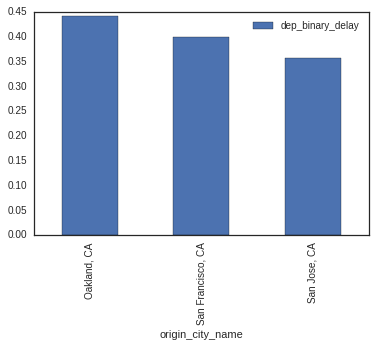

In [116]:
ms_city = bay[['dep_binary_delay','dep_delay','origin_city_name','dest_city_name']]
city_exp_value = ms_city.groupby('origin_city_name').mean().reset_index()
new= city_exp_value.sort('dep_binary_delay',ascending=False)
new.plot(x='origin_city_name',y='dep_binary_delay', kind='bar')

/home/dsi-student/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


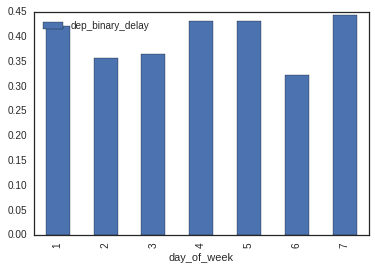

In [118]:
ms_dow = bay[['dep_binary_delay','dep_delay','day_of_week','dest_city_name']]
dow_exp_value = ms_dow.groupby('day_of_week').mean().reset_index()
dow_exp_value.sort('dep_binary_delay',ascending=False)
dow_exp_value.plot(x='day_of_week', y="dep_binary_delay", kind = 'bar')

/home/dsi-student/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


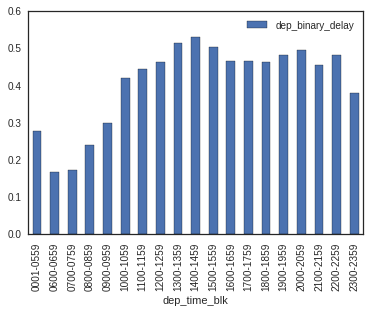

In [113]:
ms_tb = bay[['dep_binary_delay','dep_delay','dep_time_blk','dest_city_name']]
tb_exp_value = ms_tb.groupby('dep_time_blk').mean().reset_index()
tb_exp_value.sort('dep_time_blk',ascending=True)
tb_exp_value.plot(x='dep_time_blk',y='dep_binary_delay', kind='bar')

/home/dsi-student/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


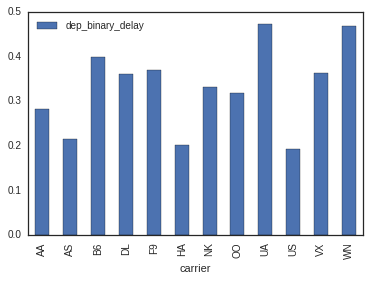

In [9]:
ms_carrier = bay[['dep_binary_delay','dep_delay','carrier','dest_city_name']]
carrier_exp_value = ms_carrier.groupby('carrier').mean().reset_index()
carrier_exp_value.sort('dep_binary_delay',ascending=False)
carrier_exp_value.plot(x='carrier', y="dep_binary_delay", kind = 'bar',sort_columns=False)

### Modeling and Results

I initially used Logistic Regression techniques (ridge and lasso) so that I could get the coefficients
on each of my predictors in my data. After starting with Logistic Regression, I implemented Decision Tree Classifiers, and Random Forest classifiers. I found that using a stochastic gradient descent (SGD) classifier with an elastic net penalty performed the best. To find the best parameters for the SGD classifier I used a cross validated grid search with a wide range of values to search for the alpha and l1 ratio. After finding the best parameters from the wide range search, I narrowed my search to find the best possible parameters. Then I fit my model on a 70% of my data before predicting on the holdout data (last 30%).

The SGD Classifier performed well for such a large dataset with 66.06% accuracy, about a 6% increase over the baseline of 60.14%. The model predicted 28,659 non-delayed flights correctly (True Negatives) and 7,760 delayed flights correctly (True Positives).  While predicting 13,974 flights wouldn't be delayed that actually were (False Negatives) and predicting 4,740 flights would be delayed that were not (False Positives). These values are shown in the confusion matrix below. SKLearn has 3 metrics that describe the confusion matrix: precision, recall, and f-1 score.  Precision is how the percentage of predicted true values that were actually true.  Recall is the percentage of actually true values that the model identified as true. F1 score is weighted average of precision and recall. 

For on time flights the model has a precision of 67%, recall of 86%, and an F1 score of 75%. For delayed flights the model has a precision of 62%, recall of 36%, and an f1 score of 45%. For the overall model precision was 65%, the recall was 66%, and the f1 score was 64%. This was with 33,399 on time flights and 21,734 delayed flights that were tested, totalling 55,133 tested flights.

Another metric commonly used to show the accuracy of your model is the reciever operating characteristic (ROC) score. This metric compares the true positive rate to the false positive rate.  The ideal model will score 1.0 and a worthless model will score at .50.  My model scored somewhere in between at 0.696. Below you will see a graph showing my ROC curve comparing true and false positive rates. 

Overall the scoring metrics were  good, with better performance for on time flights. As delayed flights are a more rare event they are harder to predict, these metrics make sense. With such a large dataset there is some inherent noise that can be hard to filter out, but on the whole this SGD Classifier model has fairly strong prediction power.

In [4]:
bay_raw = pd.read_pickle('./BAYAREA_ONLY_FINAL')

In [5]:
#After looking at all of relevant columns in my dataset I subseted to only the pertinent columns for modeling
bay = bay_raw[['dep_binary_delay','month','day_of_week','distance','dep_time_blk','origin_airport_id','carrier']]

In [6]:
#Below is my patsy formula to predict delays.
formula = 'dep_binary_delay ~ C(month) + C(day_of_week) + distance + C(dep_time_blk) + C(origin_airport_id) + C(carrier) -1'

#I use patsy to split up my target (binary delay) and the rest of my predictor, and I do so in a dataframe format. 
Y, X = patsy.dmatrices(formula, data=bay, return_type='dataframe')

In [7]:
#Here I standardize my data to a mean around 0 to account for the fact that I have a continuous variable (distance)
# included with all of my categorical variables
X_cols = X.columns
Xn = (X - X.mean()) / X.std()
Xn = Xn.values
Y = np.ravel(Y)

In [8]:
#Here I create test and train sets so that I will later have hold out data to test my models.
x_train, x_test,y_train, y_test = train_test_split(Xn,Y, test_size=.3)

In [9]:
#Here is set up a grid search for a stochastic gradient descent classifier using elastic net penalty.
sgdc = SGDClassifier()

sgdc_params = {
    'loss':['log'],
    'penalty':['elasticnet'],
    'n_iter':[5],
    'alpha':np.logspace(-4, 4, 10),
    'l1_ratio':[0.0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
}

sgdc_gs = GridSearchCV(sgdc, sgdc_params, cv=5, verbose=1, n_jobs=1)


In [10]:
sgdc_gs.fit(Xn,Y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   25.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  1.6min
[Parallel(n_jobs=1)]: Done 400 out of 400 | elapsed:  3.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['elasticnet'], 'loss': ['log'], 'alpha': array([  1.00000e-04,   7.74264e-04,   5.99484e-03,   4.64159e-02,
         3.59381e-01,   2.78256e+00,   2.15443e+01,   1.66810e+02,
         1.29155e+03,   1.00000e+04]), 'l1_ratio': [0.0, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99], 'n_iter': [5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [11]:
#There are the best parameters and score of my gridsearch on the SGD Classifier
print sgdc_gs.best_params_
print sgdc_gs.best_score_

{'n_iter': 5, 'alpha': 0.046415888336127774, 'loss': 'log', 'penalty': 'elasticnet', 'l1_ratio': 0.1}
0.615484236073


In [12]:
sgdc_bay_1 = sgdc_gs.best_estimator_

In [13]:
#After finding some general parameters I run another gridsearch with more a more specific parameter set 
#This will help me hone in on the best parameters. 
sgdc = SGDClassifier()

sgdc_params = {
    'loss':['log'],
    'penalty':['elasticnet'],
    'n_iter':[5],
    'alpha':np.logspace(-4, 4, 10),
    'l1_ratio':[0.05,0.06,0.07,0.08,0.09,0.1,0.12,0.13,0.14,0.15,0.2]
}

sgdc_gs = GridSearchCV(sgdc, sgdc_params, cv=5, verbose=1, n_jobs=1)

In [14]:
sgdc_gs.fit(Xn,Y)

Fitting 5 folds for each of 110 candidates, totalling 550 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:   28.3s
[Parallel(n_jobs=1)]: Done 199 tasks       | elapsed:  1.8min
[Parallel(n_jobs=1)]: Done 449 tasks       | elapsed:  4.4min
[Parallel(n_jobs=1)]: Done 550 out of 550 | elapsed:  5.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['elasticnet'], 'loss': ['log'], 'alpha': array([  1.00000e-04,   7.74264e-04,   5.99484e-03,   4.64159e-02,
         3.59381e-01,   2.78256e+00,   2.15443e+01,   1.66810e+02,
         1.29155e+03,   1.00000e+04]), 'l1_ratio': [0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.12, 0.13, 0.14, 0.15, 0.2], 'n_iter': [5]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [15]:
#These are the final best parameters from the gridsearch.
print sgdc_gs.best_params_
print sgdc_gs.best_score_

{'n_iter': 5, 'alpha': 0.046415888336127774, 'loss': 'log', 'penalty': 'elasticnet', 'l1_ratio': 0.08}
0.617492137081


In [16]:
#Model with the best parameters from the gridsearch
sgdc_bay_2 = sgdc_gs.best_estimator_

In [17]:
#Fitting the model with the training set from the dataset
sgdc_bay_2.fit(x_train,y_train)

SGDClassifier(alpha=0.046415888336127774, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.08,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [18]:
#scoring the model with the holdout or test data.
sgdc_bay_2.score(x_test,y_test)

0.66056626702700738

In [19]:
#Above is thge model's accuracy score and below is the baseline score.
max(np.mean(Y),1-np.mean(Y))

0.60143437047678128

In [20]:
#Creating predictions and prediction probabilities for for the x_test holdout set
y_pred = sgdc_bay_2.predict(x_test)
y_pred_prob = sgdc_bay_2.predict_proba(x_test)

In [21]:
#Confusion Matrix for predictions
print confusion_matrix(y_test, y_pred)

[[28659  4740]
 [13974  7760]]


In [22]:
#Classification report based on confusion matrix
print classification_report(y_test, y_pred, target_names = ['On Time','Delayed'])

             precision    recall  f1-score   support

    On Time       0.67      0.86      0.75     33399
    Delayed       0.62      0.36      0.45     21734

avg / total       0.65      0.66      0.64     55133



In [23]:
#ROC score
roc_auc_score(y_test, y_pred_prob[:,1])

0.69557874387658758

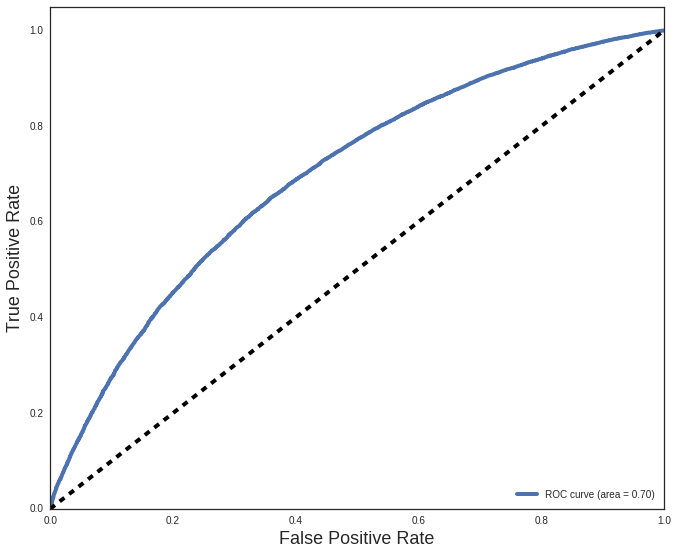

In [24]:
#Graphing the ROC Curve
Y_score = y_pred_prob[:,1]

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])

# Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### Interpreting Coefficients and Predictors Impact on Flight Delays

One of the great upsides to using a SGD Classifier with elastic net penalty is that the elastic net will select only significant predictors to use in the model while also assigning coefficients to the predictors showing the extent of their impact on the target. This provides strong insight into what to flight attributes to avoid when flying out of Bay Area airports. Below is a dataframe with each of the predictors and their corresponding coefficients.

Some of the predictors did not have enough of an impact to be included in the model these predictors included:

Origin city of San Francisco, depature month of February or May, departures on Mondays and Thursdays, departure times of 1000-1059am, 1100-1159am, 900-959pm, 1100-1159pm, and flights on Frontier Airlines, Jet Blue, Delta Airlines, Spirit Airlines, and Virgin America.

The rest of the predictors had a significant impact on the chance of fligh delays. 


#### Airlines:
Increased Chance of Delay: Southwest(0.21), United (0.14)
   
Decreased Chance of Delay: Alaska (-0.1), US(-0.04), Hawaiian(-0.03), SkyWest(-0.03)
   
   
In this model flying on Southwest and United Airlines are the two strongest influences on delay of any of the predictors. Anecdoteally Southwest and United Airlines have both had had very negative public perceptions about their on time performance. This model gives credance to the public perceptions. As a frequent Alaska Airlines flier, I was not suprised to see that the airline had the strongest negative coefficient of any airline.
   

#### Month:
Increased Chance of Delay: December(.11), June(0.06), July(0.02), August(0.02)
   
Decreased Chance of Delay: October(-0.07), September(-0.05), March(-0.02), April(-0.02), January(-0.01), November(-0.003)

In inspecting the categorical month variables, I was not surprised to see the summer months as contributors of delays. Many consumers enjoy traveling in the summer months to enjoy the good weather around the United States. It also made sense that December recieved the most delays because many people travel during the winter holiday season, and that time of year is also susceptible to weather delays.


#### Day of the Week:
Increased Chance of Delay: Sunday(0.02), Friday (0.01)
   
Decreased Chance of Delay: Saturday(-0.08), Tuesday(-0.07), Wednesday (-0.06)


With the standard Monday - Friday 5 day work week in the United States, many people like the travel for the weekends making Friday and Sunday prime time travel days. With more people traveling it make sense that airport would get congested and those two days would correlate with delays. Under the same logic, it makes sense that travelig mid week on a Tuesday and Wednesday would decrease the chance of delays. Saturday, while a weekend day ,is in the middle of the weekend and is a less ideal time to travel because it doesn't allow travler to maximize on their weekend. With less people traveling on Saturday there is less chance of congestion and delays.



#### Time of Day:
   
Increased Chance of Delay: 1400-1459 (0.08), 1500-1559 (0.06), 2000-2059 (0.06),1700-1759 (0.03), 1200-1259 (0.03), 1600-1659 (0.04), 1900-1959 (0.04), 1800-1859 (0.04)
   
Decreased Chance of Delay: 0600-0659 (-0.25), 0700-0759,(-0.20),0800-0859(-0.15), 0900-0959 (-0.08)

This model shows that traveling earlier in the day decreases your chance of being delayed. This manifests because any flight delays can cause backups at the airport making subsequent flights that daty delayed.
   
#### Distance - 0.07

Distance had a positive coefficient meaning the farther you fly the more likely for there to be a delay. The farther an aircraft has to fly the more preparation an airplane requires and the less aircrafts are elligible to make the flight. It can be harder to find replacement aircrafts and to do any maintenance that may be required.

Please see the graph below to see the direction and strength of each predictor.


In [25]:
sgdc_bay_2.coef_

array([[-0.01464667,  0.        , -0.01562262, -0.015302  ,  0.        ,
         0.05669379,  0.05629494,  0.01605588, -0.05374845, -0.06515352,
        -0.00354028,  0.10620783, -0.06706968, -0.05775627,  0.        ,
         0.01138492, -0.08404523,  0.01914313, -0.24751984, -0.2033653 ,
        -0.15443686, -0.0798316 ,  0.        ,  0.        ,  0.0347445 ,
         0.07078245,  0.07969641,  0.06441702,  0.03676717,  0.02662333,
         0.0433382 ,  0.03782547,  0.05648882,  0.        ,  0.01535398,
         0.        ,  0.        , -0.05514436, -0.09974601,  0.        ,
         0.        ,  0.        , -0.02874589,  0.        , -0.02571494,
         0.13800101, -0.03992901,  0.        ,  0.21302785,  0.07283192]])

In [26]:
col_coefs_list = zip(X.columns,sgdc_bay_2.coef_[0])

In [27]:
#Creating datafram with predictor coefficients
c = pd.DataFrame(col_coefs_list)
c.columns = ['feature','coef']
c.sort('coef',ascending=True, inplace = True)
c

/home/dsi-student/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,coef
18,C(dep_time_blk)[T.0600-0659],-0.247520
19,C(dep_time_blk)[T.0700-0759],-0.203365
20,C(dep_time_blk)[T.0800-0859],-0.154437
38,C(carrier)[T.AS],-0.099746
16,C(day_of_week)[T.6],-0.084045
21,C(dep_time_blk)[T.0900-0959],-0.079832
12,C(day_of_week)[T.2],-0.067070
9,C(month)[10],-0.065154
13,C(day_of_week)[T.3],-0.057756
37,C(origin_airport_id)[T.14831],-0.055144


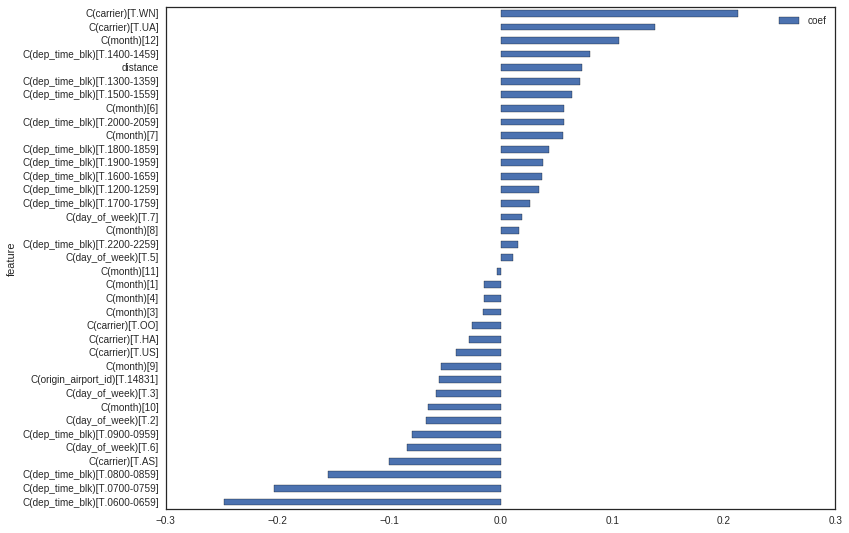

In [28]:
#Graphing non-zero predictor coefficients
mask = c.coef!=0
c[mask].plot(x='feature',y='coef',kind='barh', figsize = (12,9))

### User Input

After cleaning my data and finding the correct model, I implemented the user input to complete my tool. To get user input I created dropdown menu's to allow the user to pick the various attributes of their upcoming flight. I created lists of valid, unique attributes and setup my dropdown selections using ipywidgets.  Then I created 3 dummy rows with the user input, normalized them, and predicted the probability of delay using the SGD Classifier I setup above. Finally I printed the predicted probabilities to the user, and using an serier of if statements printed a recommendation which airport to fly from.

In [10]:
#load in the model with the best parameters from above
sgdc_ui = sgdc_bay_2

NameError: name 'sgdc_bay_2' is not defined

In [89]:
#create unique lists of destination cities, days of the week, months, time blocks, and carriers
bay_dest = bay_raw.dest_city_name.unique().tolist()
day_of_week_select = bay_raw.day_of_week.unique().tolist()
month_select = bay_raw.month.unique().tolist()
time_blocks_select = bay_raw.dep_time_blk.unique().tolist()
carrier_select = bay_raw.carrier.unique().tolist()

In [ ]:
#this creates a function to be run on the click of the submit button that will print out all of the users selections
def test(val):
    print "Submitted!"
    print "Destination City: ", destination.value
    print "Airline: ", airline.value
    print "Departure Month: ", month.value 
    print "Day of the Week: ", day_of_week.value
    print "Departure Time: ", time_of_day.value
#     predict_funct(val)


#creates user input drop down for destination
destination = Dropdown(
    options= bay_dest,
    value= bay_dest[0],
    description='Dest. City: ',
)

month = Dropdown(
    options=month_select,
    value= month_select[0],
    description='Month: ',
)

day_of_week = Dropdown(
    options=day_of_week_select,
    value= day_of_week_select[0],
    description='Day of the Week: ',
)

time_of_day = Dropdown(
    options= time_blocks_select,
    value= time_blocks_select[0],
    description='Hour of Flight: ',
)

airline = Dropdown(
    options=carrier_select,
    value= carrier_select[0],
    description='Airline: '
)


# Creates submit button and event for when buttons is clicked, which I set to the function test, made above
submit_button = Button(description="Submit Info")
submit_button.on_click(test)

#displays dropdowns and submit button
display(destination)
display(airline)
display(month)
display(day_of_week)
display(time_of_day)
    
display(submit_button)


Submitted!
Destination City:  Atlanta, GA
Airline:  DL
Departure Month:  1
Day of the Week:  4
Departure Time:  2300-2359


In [92]:
sj_id = 14831
sf_id = 14771
oak_id = 13796

In [93]:
#creates lists of the input values, 3 in each list (one for each bay area airport)
predictions_dow = [day_of_week.value, day_of_week.value, day_of_week.value]
predictions_mon = [month.value,month.value,month.value]
predictions_time = [str(time_of_day.value),str(time_of_day.value), str(time_of_day.value)]
predictions_og_aiport = [sj_id,sf_id,oak_id]
predictions_airline = [airline.value,airline.value,airline.value]

In [95]:
#creates the distance list (not input by user), pulled from full data set
mask_sj_dest = bay['origin_airport_id']==sj_id
mask_sf_dest = bay['origin_airport_id']==sf_id
mask_oak_dest = bay['origin_airport_id']==oak_id

sj_dist = bay[mask_sj_dest]['distance'].mean()
sf_dist = bay[mask_sf_dest]['distance'].mean()
oak_dist = bay[mask_oak_dest]['distance'].mean()

predictions_distance = [sj_dist,sf_dist,oak_dist]

In [96]:
#creates a dictionary with all of the user input
pred_dict = {'month':predictions_mon,'day_of_week':predictions_dow,'distance':predictions_distance,
             'dep_time_blk':predictions_time,'origin_airport_id':predictions_og_aiport,'carrier':predictions_airline,'dep_binary_delay':[0,0,0]}

In [98]:
#creates three rows with the same values except for distance and origin airport to allow predictions
#then adds this dataframe to the full data to be patsied so we can predict on the 3 rows
predictions_df = pd.DataFrame(pred_dict)
bay_sub_1 = bay.append(predictions_df)

In [99]:
#patsy all the data including 3 prediction rows
formula = 'dep_binary_delay ~ C(month) + C(day_of_week) + distance + C(dep_time_blk) + C(origin_airport_id) + C(carrier) -1'


Y, X = patsy.dmatrices(formula, data=bay_sub_1, return_type='dataframe')

In [100]:
#pull out the 3 prediction rows
pred_3 = X.tail(3)


In [101]:
#standardize the rows
ss = StandardScaler()
X3n = ss.fit_transform(pred_3)


In [104]:
#predict on the 3 user input rows
predictions_final_perc = sgdc_ui.predict_proba(X3n)

In [105]:
#pull out the prediction percentages for each airport
sj_final_pred = predictions_final_perc[0][1]
sf_final_pred = predictions_final_perc[1][1]
oak_final_pred = predictions_final_perc[2][1]

In [106]:
#Print out the results and use if statements to make a recommendation on which airport to fly out of.
print "Based on your selection there is a " + str(round((sj_final_pred*100),2)) + "% chance of delay at the San Jose Airport."
print "Based on your selection there is a " + str(round((sf_final_pred*100),2)) + "% chance of delay at the San Francisco Airport."
print "Based on your selection there is a " + str(round((oak_final_pred*100),2)) + "% chance of delay at the Oakland Airport. \n"

if (sj_final_pred < oak_final_pred) & (sj_final_pred < sf_final_pred):
    print "I suggest you fly out of San Jose to avoid delays"
elif (sf_final_pred < oak_final_pred) & (sf_final_pred < sj_final_pred):
    print "I suggest you fly out of San Francisco to avoid delays"
else:
    print "I suggest you fly out of Oakland to avoid delays"

Based on your selection there is a 37.0% chance of delay at the San Jose Airport.
Based on your selection there is a 41.54% chance of delay at the San Francisco Airport.
Based on your selection there is a 38.91% chance of delay at the Oakland Airport. 

I suggest you fly out of San Jose to avoid delays
